In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft
from scipy.optimize import curve_fit as cf
import torch
import torch.nn as nn
import matplotlib.cm as cm
color =cm.viridis
def load_data(N,difftemp,P,temp,nSteps,dt,last = True):
    if last:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
    else:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
def load_original_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)
def expfit(x,a,b,c):
    return a*np.exp(-x/b)+c

In [2]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)

L = 10
N = L**2
P = 100000
difftemp = 8
nSteps = 300
dt = 0.02
Ts[10]

2.77

In [38]:
slices = np.geomspace(1,nSteps,9, dtype = np.int32) 
del x_recon
del x_true

NameError: name 'x_true' is not defined

In [3]:
x_recon = np.empty((meas,P,9,N))
for i,T in enumerate(Ts):
    x_recon[i] = load_data(N,difftemp,P,T,nSteps,dt)
x_true = np.empty((meas,200000,N))
for i,T in enumerate(Ts):
    x_true[i] = load_original_data(L,T,200000)

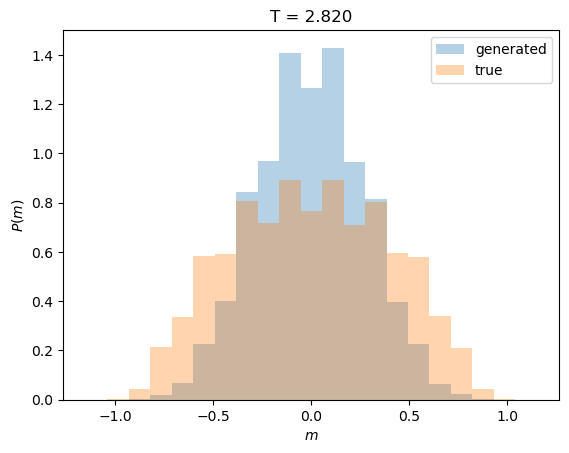

In [5]:
idx= 11
plt.title(f"T = {Ts[idx]:.3f}")
plt.hist(np.mean(np.sign(x_recon[idx,:,-1,:]),axis = 1),range=(-1.15,1.15),bins = 21,alpha = 1/3,density = True, label = "generated")
#plt.hist(np.mean(x_recon[idx,:,-1,:],axis = 1),range=(-1.15,1.15),bins = 21,alpha = 1/3,density = True, label = "generated no sign")
plt.hist(np.mean(x_true[idx],axis = 1),range=(-1.15,1.15),bins = 21,alpha =1/3,density = True, label = "true")
plt.ylabel(r"$P(m)$")
plt.xlabel(r"$m$")
plt.legend()

In [4]:
def radial_corr(data):
    N = data.shape[1]
    L = int(N**0.5)
    rsq = np.array([])
    gr = np.array([])
    covmat = torch.cov(data.T)
    for i in range(N):
        ix = i%L
        iy = np.floor(i/L).astype(np.int32)
        for j in range(i,N):
            jx = j%L
            jy = np.floor(j/L).astype(np.int32)
            rsq = np.append(rsq, (ix-jx)**2 + (iy-jy)**2)
            gr = np.append(gr,covmat[i][j].numpy())
    ord = np.argsort(rsq)
    ordgr = gr[ord]
    ordrsq = rsq[ord]
    dist, dist_c = np.unique(np.sqrt(rsq), return_counts=True)
    start = 0
    gr = np.array([])
    for i in range(len(dist_c)):
        end = start + dist_c[i]-1
        gr = np.append(gr,np.mean(ordgr[start:end]))
        start = end +1
    table = dist < (L)/2
    return dist[table],gr[table]

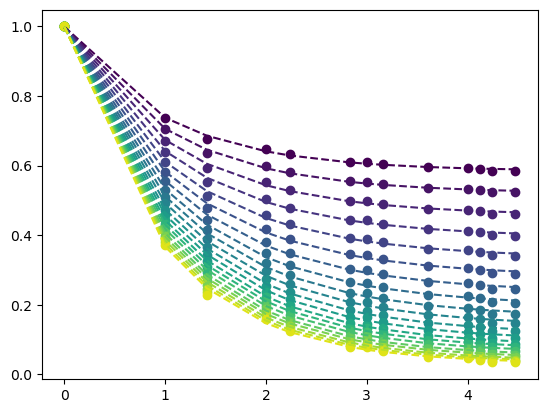

In [7]:
gr = np.array([])
fits = np.array([])
for i in range(20):
    dist,tmp = radial_corr(torch.from_numpy(x_true[i]))
    popt,pcov = cf(expfit,dist,tmp/tmp[0])
    plt.scatter(dist,tmp/tmp[0],color = color(i/20))
    plt.plot(dist,expfit(dist,*popt),color = color(i/20),linestyle = "--")
    gr = np.append(gr, tmp/tmp[0])
    fits = np.append(fits, popt)
    
#plt.yscale("log")
gr=gr.reshape(20,-1)
fits=fits.reshape(20,-1)

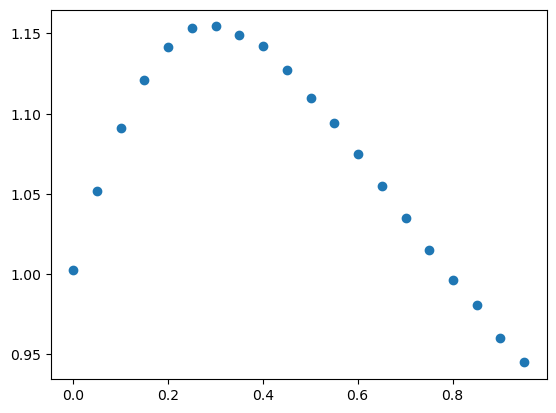

In [8]:
Tc = 2/np.log(1+np.sqrt(2))
table =Ts > 0
plt.scatter((Ts[table]-Tc),fits[table,1])
#plt.plot((Ts[8:]-Tc),0.25*(Ts[8:]-Tc)+0.6)
#plt.xscale("log")
#plt.yscale("log")

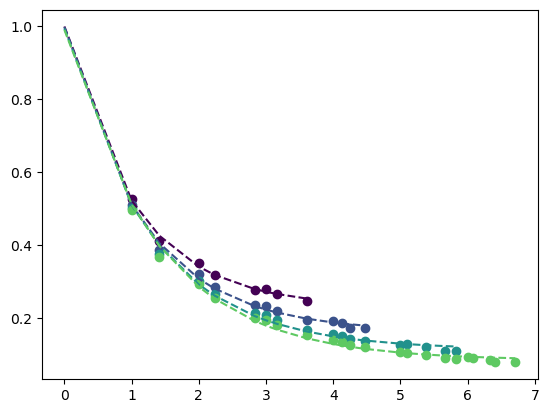

In [53]:
Ls = np.array([8,10,12,14])
T = Ts[8]
gr = np.array([])
fits = np.array([])
for i,L in enumerate(Ls):
    data = load_original_data(L,T,200000)
    dist,tmp = radial_corr(data)
    popt,pcov = cf(expfit,dist,tmp)
    plt.scatter(dist[1:],tmp[1:],color = color(i/4))
    plt.plot(dist,expfit(dist,*popt),color = color(i/4),linestyle = "--")
    fits = np.append(fits, popt)
#plt.xscale("log")
#plt.yscale("log")


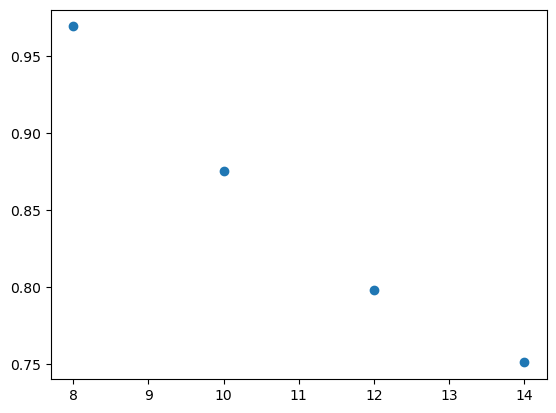

In [56]:
plt.scatter(Ls,fits.reshape(4,-1)[:,1])

In [14]:
fits.shape

(12,)

In [12]:
largeeval = np.array([])
for i in range(20):
    C0 = np.cov(x_true[i].T)
    eval,evec = np.linalg.eig(C0)
    largeeval = np.append(largeeval,eval[0])

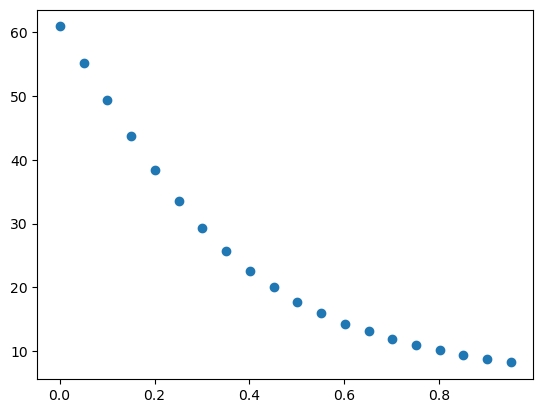

In [21]:
Tc = 2/np.log(1+np.sqrt(2))
plt.scatter(Ts-Tc,largeeval)
#plt.xscale("log")
#plt.yscale("log")

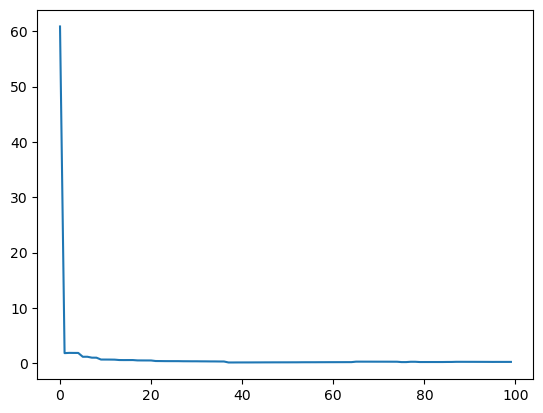

In [11]:
plt.plot([*range(100)],eval)